**Programmabibliotheken in notebook laden**

In [1]:
import dependencies
import jupyter_addons as ja

In [2]:
ja.set_css()

In [3]:
import pandas as pd
from lib import Analyzer
import quantities as qty
from pypeflow.core.flow_coefficient import FlowCoefficient
from pypeflow.core.resistance_coefficient import ResistanceCoefficient
from pypeflow.core.fluids import Water
from pypeflow.core.pipe_schedules import PipeSchedule40
from pypeflow.utils.system_curve import SystemCurve

# Analyse leidingnetwerk van 1 appartement

**Gegeven:**
- Ontwerpvolumedebieten van de aftappunten cf. tabel 2 van DIN 1988-300: zie schema
- Resulterende volumedebieten in de takken van het leidingnetwerk: zie schema
- **De opvoerdruk aan het begin van de installatie (3 bar)**
- De pijpdiameters en lengten van de leidingtakken.
- De berekende weerstandscoëfficiënten (*zeta*-waarden) van de aftappunten (cf. de ontwerpwaarden in tabel 2 van DIN 1988-300)

<h4><mark>Het vraagstuk luidt welke volumedebieten in het leidingnetwerk zullen stromen bij de gegeven opvoerdruk.</mark></h4>

![schema leidingnetwerk appartement](./static/scheme_apartment.png)

## Configuratiebestand leidingnetwerk

In [4]:
df_input = pd.read_csv('.\\input_files\\hardy_apartment.csv')
ja.display_table(df_input)

,loop_id,section_id,start_node_id,end_node_id,nom_diameter [mm],length [m],zeta,a0,a1,a2,dp_fixed [bar],flow_rate [L/s]
0,l1,s01,n0,n1,20.0,6.0,3.600,NaN,NaN,NaN,NaN,0.86
1,l1,s11*,n1,n1*,15.0,1.6,1574.368,NaN,NaN,NaN,NaN,0.07
2,l1,s1*0*,n1*,n0*,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
3,l1,s00*,n0,n0*,NaN,NaN,NaN,NaN,NaN,NaN,-3.0,NaN
4,l2,s12,n1,n2,20.0,1.8,3.600,NaN,NaN,NaN,NaN,0.79
5,l2,s25,n2,n5,15.0,0.6,3.890,NaN,NaN,NaN,NaN,0.44
6,l2,s52*,n5,n2*,15.0,1.0,345.905,NaN,NaN,NaN,NaN,0.15
7,l2,s2*1*,n2*,n1*,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
8,l2,s11*,n1,n1*,15.0,1.6,1574.368,NaN,NaN,NaN,NaN,-0.07
9,l3,s56,n5,n6,15.0,0.9,49.641,NaN,NaN,NaN,NaN,0.29


## `Analyzer` configureren

### Ingave van de in het configuratiebestand gebruikte en gewenste maateenheden 

In [5]:
Analyzer.set_units({
    'length': 'm',
    'diameter': 'mm',
    'flow_rate': 'L/s',
    'pressure': 'bar',
    'velocity': 'm/s'
})

### Initialisatie van het leidingnetwerkmodel

- begin- en eindknooppunt van het netwerk (daarmee kan de `Analyzer` de stroompaden in het leidingnetwerk zoeken)
- het soort fluïdum: water
- de temperatuur van het water
- het aangewende pijpmateriaal (maatnorm *Pipe Schedule 40*)

In [6]:
Analyzer.create_network(
    start_node_id='n0',
    end_node_id='n0*',
    fluid='water',
    fluid_temperature=10.0,
    pipe_schedule='pipe_schedule_40'
)

### Configuratiebestand koppelen aan de `Analyzer`

In [7]:
Analyzer.configure_network('.\\input_files\\hardy_apartment.csv')

## Analyse laten uitvoeren

De `Analyzer` berekent de debieten en de daarmee gepaard gaande drukverliezen in het leidingnetwerk.

In [8]:
Analyzer.solve(error=1.0e-3, i_max=5000)

## Resultaat

In [9]:
df_output = Analyzer.get_network()
ja.display_table(df_output)

,loop_id,section_id,start_node_id,end_node_id,length [m],diameter [mm],zeta,flow_rate [L/s],velocity [m/s],pressure_drop [bar]
0,l1,s01,n0,n1,6.0,20.0,3.600,1.162,3.354,0.632
1,l1,s11*,n1,n1*,1.6,15.0,1574.368,0.107,0.548,2.368
2,l1,s1*0*,n1*,n0*,NaN,NaN,NaN,NaN,NaN,0.000
3,l1,s00*,n0,n0*,NaN,NaN,NaN,NaN,NaN,-3.000
4,l2,s12,n1,n2,1.8,20.0,3.600,1.054,3.044,0.274
5,l2,s25,n2,n5,0.6,15.0,3.890,0.521,2.655,0.177
6,l2,s52*,n5,n2*,1.0,15.0,345.905,0.206,1.050,1.917
7,l2,s2*1*,n2*,n1*,NaN,NaN,NaN,NaN,NaN,0.000
8,l2,s11*,n1,n1*,1.6,15.0,1574.368,-0.107,-0.548,-2.368
9,l3,s56,n5,n6,0.9,15.0,49.641,0.315,1.605,0.662


## Hydraulische weerstand en systeemcurve van het leidingnetwerk onder ontwerpcondities

Ontwerpcondities: alle aftappunten staan open; de opvoerdruk aan het begin van de installatie is gegeven.

### Totaal volumedebiet dat het leidingnetwerk binnenstroomt bij de gegeven opvoerdruk (3 bar)

Het totaal volumedebiet stroomt vanaf leidingsectie *S01* naar de diverse aftappunten in de installatie.

In [10]:
V_nw = Analyzer.network.flow_rate
ja.display_item(f"Het totaal volumedebiet bedraagt: <b>{V_nw('L/s'):.3f}</b> L/s")

In [11]:
dp_nw = Analyzer.network.pressure_drop
ja.display_item(f"Het drukverlies tussen start- en eindknoop van het netwerk: <b>{dp_nw('bar'):.3f}</b> bar")

### Equivalente doorstroom- en weerstandscoëfficiënt van het netwerk

In [12]:
Kv_nw = FlowCoefficient.calc_Kv(V_nw, dp_nw, Water(10.0))
ja.display_item(f"Equivalente doorstroomcoëfficiënt <em>Kv</em> van het netwerk: <b>{Kv_nw:.3f}</b>")

In [13]:
dn = qty.Length(40, 'mm')
di = PipeSchedule40.inside_diameter(dn)
zeta_nw = ResistanceCoefficient.from_Kv(Kv_nw, di)
ja.display_item(f"Equivalente weerstandscoëfficiënt <em>zeta</em> van het netwerk gerefereerd aan DN{dn('mm'):.0f}: <b>{zeta_nw:.3f}</b>")

### Systeemcurve van het leidingnetwerk

De systeemcurve geeft het verband weer tussen het totaal volumedebiet dat het netwerk binnenstroomt en de opvoerdruk aan het begin van het netwerk.

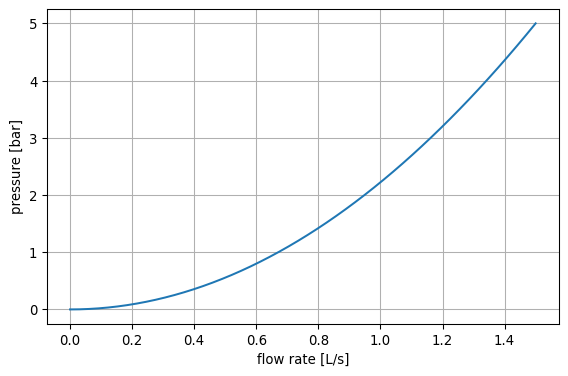

In [14]:
curve = SystemCurve(R=FlowCoefficient.Kv_to_R(Kv_nw), desired_units={'flow_rate': 'L/s', 'pressure': 'bar'})
diagram = curve.draw_system_curve(
    V_start=qty.VolumeFlowRate(0.0, 'L/s'),
    V_end=qty.VolumeFlowRate(1.5, 'L/s')
)
diagram.show()

<mark>**Per verdieping zijn er 3 appartementen aangesloten op de stijgleiding**</mark><br>
Dit betekent voor dezelfde opvoerdruk (3 bar) een 3x groter volumedebiet op het niveau van de verdieping.

In [15]:
# V_fl = qty.VolumeFlowRate(3 * V_nw())
# Kv_fl = FlowCoefficient.calc_Kv(V_fl, dp_nw, Water(10.0))
Kv_fl = 3 * Kv_nw
zeta_fl = ResistanceCoefficient.from_Kv(Kv_fl, di)
ja.display_item(f"Equivalente doorstroomcoëfficiënt <em>Kv</em> op verdiepingsniveau: <b>{Kv_fl:.3f}</b>")
ja.display_item(f"Equivalente weerstandscoëfficiënt <em>zeta</em> op verdiepingsniveau gerefereerd aan DN{dn('mm'):.0f}: <b>{zeta_fl:.3f}</b>")